# TILEs
Scripts to modify images with quadtrees, voronoitrees, dithering algorithms, etc...
Images must be open with PIL. The scripts output a dict containing all the needed informations to reconstruct polygons, but the images as well.
It was originally written for PILes.

In [1]:
# Imports
import TILEs
from PIL import Image
from PIL.ImageDraw import ImageDraw, Draw
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import PolyCollection, LineCollection

%matplotlib inline

Let's start by defining some display tools:

In [2]:
def set_ax(ax, size=(256, 256)):
    ax.axis('off') 
    ax.set_xlim(-1, size[0] + 1) # image dimensions
    ax.set_ylim(size[1] + 1, -1) # remember that images have inverted y-axis
    ax.set_aspect('equal')
    
    return ax

def show_collections(collections, cols = 2, figsize=(12, 6)):
    fig, axes = plt.subplots(figsize=figsize, ncols=cols, nrows=int(len(collections) / cols))
    ax = axes.ravel()

    for i, coll in enumerate(collections):

        ax[i] = set_ax(ax[i])
        ax[i].add_collection(deepcopy(coll))

    fig.tight_layout(pad=0.2)

As a first example, let's see what the script does to a blank image:

In [3]:
# Creating a 256*256 white image
white_img = Image.new(size=(256, 256), mode = 'RGB', color = (255, 255, 255))
voronois = []

# Let's increase the number of recursive voronoi slicing.
for level in [1, 2, 3]:
    
    # We will generate 3 images with increased slicing. The maximum slicing level is the only parameter
    vor = TILEs.voronoitree(white_img, max_level=level, std_thr=0)
    vor_coll = PolyCollection(vor['polys'], 
                          edgecolors='black', linewidths=0.5,
                          facecolors='white', alpha=1)
    voronois.append(vor_coll)


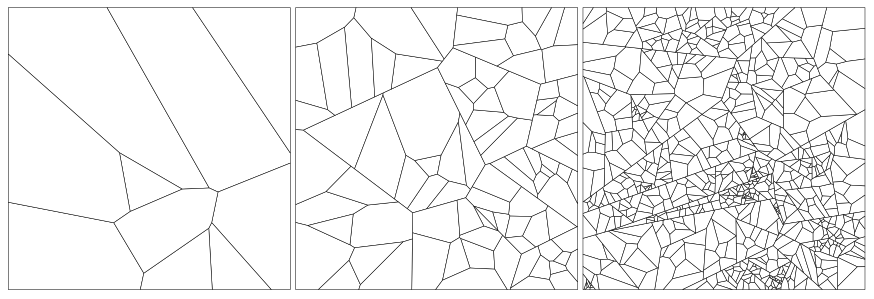

In [4]:
# And display them. We can see the image is increasingly tesselated.
show_collections(voronois, cols=3)

The tesselation script outputs a dict containing multiple keys:

In [5]:
vor.keys()

dict_keys(['top', 'left', 'x', 'y', 'width', 'height', 'shifted_polys', 'images', 'colors', 'level', 'polys'])

>'Top', 'Left', 'width' & 'height' give the bounding box of the polygon.
>'x' & 'y' are the coordinates of the middle of the polygon.
>'polys' contains the coordinates of the extracted polygon.
>'shifted_polys' contains the coordinates of the extracted polygon, but relative to the middle (x, y) of the polygon.
>'images' contain the extracted image.
>'colors' contains the average color of the polygon.
>'level' gives the recursion level of the actual polygon.


Let's see what it gives with a simple image:

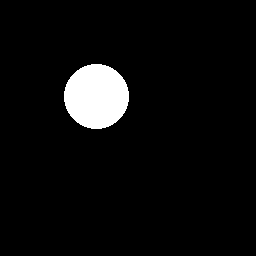

In [6]:
# creatig a black image containing a white disc.
img2 = Image.new(size=(256, 256), mode = 'RGB', color = (0, 0, 0))
img_draw = ImageDraw(img2)
img_draw.ellipse([64, 64, 128, 128], fill='white', outline=None, width=1)

display(img2)

We can tesselate it, using different standard deviation thresholds for the algorithm to stop at certain point.

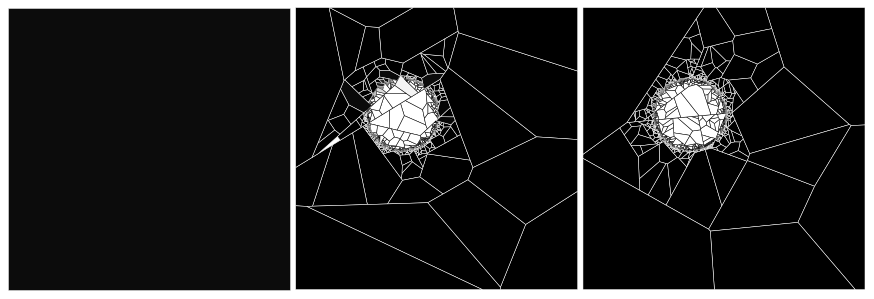

In [7]:
voronois = []
for std in [100, 56, 5]:
    # The recursion will stop when the standard deviation of the pixel values inside the polygon 
    # are less than this threshold
    vor = TILEs.voronoitree(img2, std_thr=std)
    # Let's get the colors of the polygons.
    # Colors have to be changed from RGB U8 to [0, 1] values for Matplotlib
    colors = [(r/255, g/255, b/255) for r, g, b in vor['colors']]
    # And let's invert them for the edges
    inv_colors = [(1-r, 1-g, 1-b) for r, g, b in colors]
    
    vor_coll = PolyCollection(vor['polys'], 
                          edgecolors=inv_colors, linewidths=0.5,
                          facecolors=colors, alpha=1)
    voronois.append(vor_coll)
    
show_collections(voronois, cols=3)

We can see that decreasing the standard deviation threshold increases the number of iteration.

We can use the image itself as a heightmap, to tesselate another image. Let's use the previous one to tesselate the original white image:

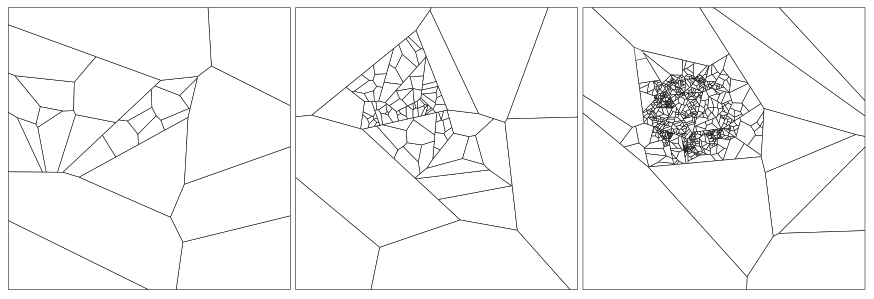

In [8]:
voronois = []
for max_level in [2, 3, 5]:
    
    # img is our white square, the heightmap is the white disc on black background.
    vor = TILEs.voronoitree(white_img, max_level = max_level, heightmap=img2, std_thr=0)
   
    vor_coll = PolyCollection(vor['polys'], 
                          edgecolors='black', linewidths=0.5,
                          facecolors='white', alpha=1)
    voronois.append(vor_coll)
    
show_collections(voronois, cols=3)

We can see that the image is increasingly tesselated according to the heightmap, until the max_level is reached.

The script can be started with any polygon as a start. For example, a circle:

In [9]:
theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
# A circle of radius 128, centered in a 256*256 plane
r = 128
x, y = r * np.cos(theta) + r, r * np.sin(theta) + r

circle = np.stack((x, y), axis=-1)

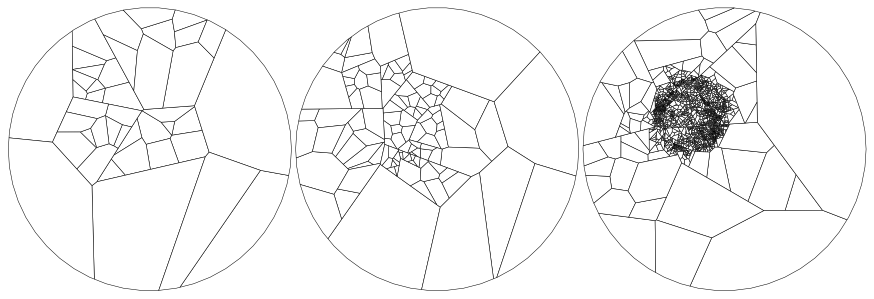

In [11]:
# let's redo the same thing
voronois = []
for max_level in [2, 3, 5]:
    
    vor = TILEs.voronoitree(white_img, max_level = max_level, heightmap=img2, std_thr=0, first_poly = circle)
    vor_coll = PolyCollection(vor['polys'], 
                          edgecolors='black', linewidths=0.5,
                          facecolors='white', alpha=1)
    voronois.append(vor_coll)
    
show_collections(voronois, cols=3)

With Chatoyant, we can quickly generate a ColorMap to apply it to the tesselated image:

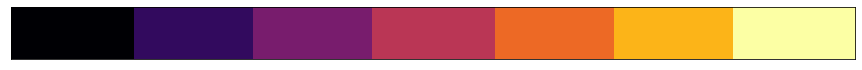

Chatoyant ColorMap inferno, length 7.

In [12]:
import Chatoyant
cmap = Chatoyant.ColorMap().from_matplotlib('inferno', n=7)
cmap

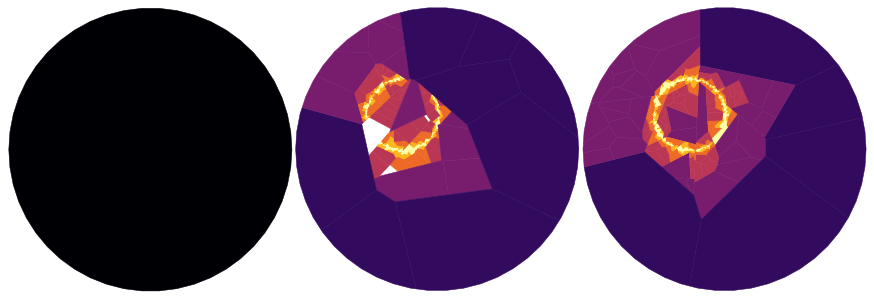

In [13]:
voronois = []
for std in [100, 58, 5]:
    
    vor = TILEs.voronoitree(img2, std_thr=std, first_poly = circle, max_level=6)
    # Let's apply the colormap according to the level of recursion
    colors = [cmap.to_float_list()[i] for i in vor['level']]
    
    vor_coll = PolyCollection(vor['polys'], 
                          edgecolors=colors, linewidths=0.5,
                          facecolors=colors, alpha=1)
    voronois.append(vor_coll)
    
show_collections(voronois, cols=3)

We can see that the tesselation is maximum at the disk perimeter.

The heightmap parameter is particularly interesting when used with real pictures. For example, let's create a basic heightmap for a mandatory Lenna:

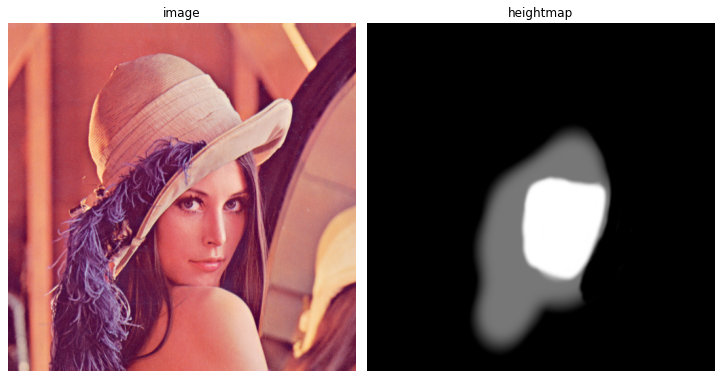

In [14]:
lenna = Image.open('Lenna.png')
heightmap = Image.open('Lenna_HM.png')

fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
ax = axes.ravel()
names = ['image', 'heightmap']

for ax, img, name in zip(axes.ravel(), [lenna, heightmap], names):
    set_ax(ax, size=(512, 512))
    ax.set_title(name)
    ax.imshow(img)
fig.tight_layout(pad=0.2)

We can use the scripts in many different ways, playing on the minimal standard deviation threshold, the heightmap and the number of maximum iterations.
Quadtree recursive slicing works exactly the same way.

In [43]:
# Voronoi tesselation with a standard deviation threshold

vorlenna = TILEs.voronoitree(lenna, std_thr=20)
colors = [(r/255, g/255, b/255) for r, g, b in vorlenna['colors']]

lenna_coll = PolyCollection(vorlenna['polys'], 
                      edgecolors=colors, linewidths=1,
                      facecolors=colors, alpha=1)

In [48]:
# Voronoi tesselation with the heightmap.

vorlenna2 = TILEs.voronoitree(lenna, heightmap=heightmap, std_thr=0, max_level=6)
colors = [(r/255, g/255, b/255) for r, g, b in vorlenna2['colors']]

lenna_coll2 = PolyCollection(vorlenna2['polys'], 
                      edgecolors=colors, linewidths=1,
                      facecolors=colors, alpha=1)

In [45]:
# Quadtree tesselation with a standard deviation threshold

quadlenna = TILEs.quadtree(lenna, std_thr=30)
colors = [(r/255, g/255, b/255) for r, g, b in quadlenna['colors']]

lenna_coll3 = PolyCollection(quadlenna['polys'], 
                      edgecolors=colors, linewidths=1,
                      facecolors=colors, alpha=1)

In [46]:
# Quadtree tesselation with heightmap

quadlenna2 = TILEs.quadtree(lenna, heightmap=heightmap, std_thr=0, max_level=7)
colors = [(r/255, g/255, b/255) for r, g, b in quadlenna2['colors']]

lenna_coll4 = PolyCollection(quadlenna2['polys'], 
                      edgecolors=colors, linewidths=1,
                      facecolors=colors, alpha=1)

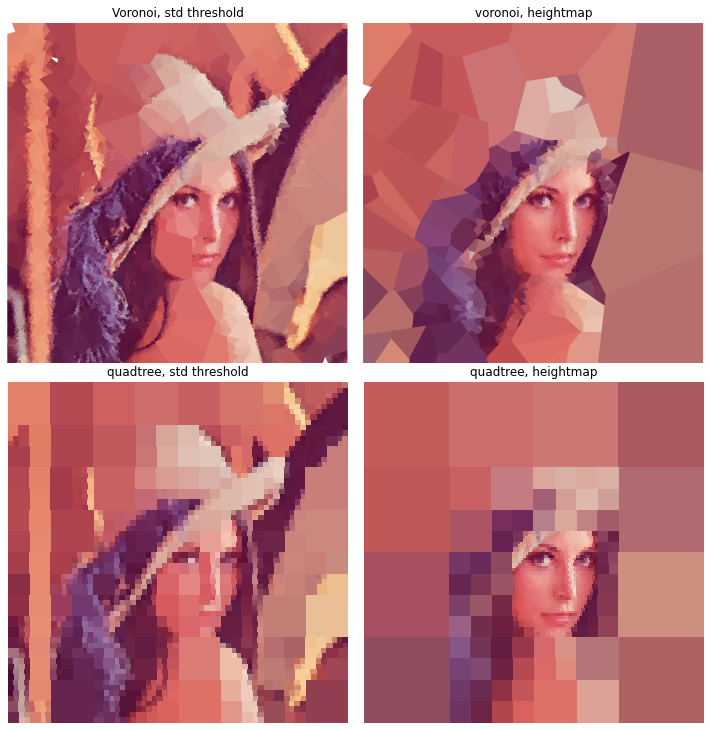

In [49]:
fig, axes = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)
names = ['Voronoi, std threshold', 'voronoi, heightmap', 'quadtree, std threshold', 'quadtree, heightmap']

for ax, coll, name in zip(axes.ravel(), [lenna_coll, lenna_coll2, lenna_coll3, lenna_coll4], names):
    set_ax(ax, size=(512, 512))
    ax.add_collection(deepcopy(coll))
    ax.set_title(name)

fig.tight_layout(pad=0.2)